In [23]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


def sterman_stn_simulation(B, k, n, T, T_start, 
                           correction_speed=0.2, 
                           pipeline_awareness=1.0, 
                           effort_lag=3):
    """
    Simulazione di una Temporal Network con regole decisionali di Sterman.
    """
    # Inizializzazione
    delays = np.zeros(n)
    # Memoria: sforzi decisi ma non ancora applicati (Pipeline)
    effort_pipeline = np.zeros((n, effort_lag))
    
    history_size = T - T_start
    metrics = {
        "time": np.arange(T_start, T),
        "mean_delay": np.zeros(history_size),
        "total_effort_decided": np.zeros(history_size),
        "wasted_effort": np.zeros(history_size),
        "variability_index": np.zeros(history_size)
    }

    all_eps = scipy.stats.expon.rvs(size=(T, n))

    for t in range(T):
        # 1. ACCOPPIAMENTO TEMPORALE (Shuffle k-regolare)
        delays_selected = np.zeros((n * k))
        for i in range(k):
            shuffled = np.random.permutation(delays)
            delays_selected[i*n : (i+1)*n] = shuffled
        
        incoming_delays = np.reshape(delays_selected, (n, k))
        max_incoming = np.maximum(0, np.max(incoming_delays, axis=1) - B)

        # 2. DECISIONE (Regole di Sterman)
        supply_line = np.sum(effort_pipeline, axis=1)
        
        # Sforzo extra basato su Backlog e Pipeline Awareness
        desired_extra_effort = correction_speed * (delays - pipeline_awareness * supply_line)
        total_decision = np.maximum(0, max_incoming + desired_extra_effort)

        # 3. ESECUZIONE (Impatto ritardato)
        active_effort = effort_pipeline[:, 0]
        potential_delay = max_incoming + all_eps[t]
        
        # Calcolo Spreco e Nuovo Ritardo
        waste = np.maximum(0, active_effort - potential_delay)
        new_delays = np.maximum(0, potential_delay - active_effort)

        # 4. AGGIORNAMENTO MEMORIA
        effort_pipeline = np.roll(effort_pipeline, -1, axis=1)
        effort_pipeline[:, -1] = total_decision

        # 5. RACCOLTA DATI
        if t >= T_start:
            idx = t - T_start
            metrics["mean_delay"][idx] = np.mean(new_delays)
            metrics["total_effort_decided"][idx] = np.mean(total_decision)
            metrics["wasted_effort"][idx] = np.mean(waste)
            metrics["variability_index"][idx] = np.std(new_delays) / (np.std(all_eps[t]) + 1e-6)

        delays = new_delays

    return metrics

In [24]:
# --- Configurazione Rete ---
N_NODES = 500
K_DEGREE = 3
BUFFER_B = 1.0
T_MAX = 600
T_WARMUP = 100

# Valori di Pipeline Awareness (Beta) da confrontare
awareness_values = [0.0, 1.0]
results = {}

print("Simulazione in corso...")
for beta in awareness_values:
    results[beta] = sterman_stn_simulation(
        B=BUFFER_B, k=K_DEGREE, n=N_NODES, T=T_MAX, T_start=T_WARMUP,
        correction_speed=0.25, 
        pipeline_awareness=beta, 
        effort_lag=4 # Tempo di risposta della rete
    )
print("Completato!")

Simulazione in corso...
Completato!


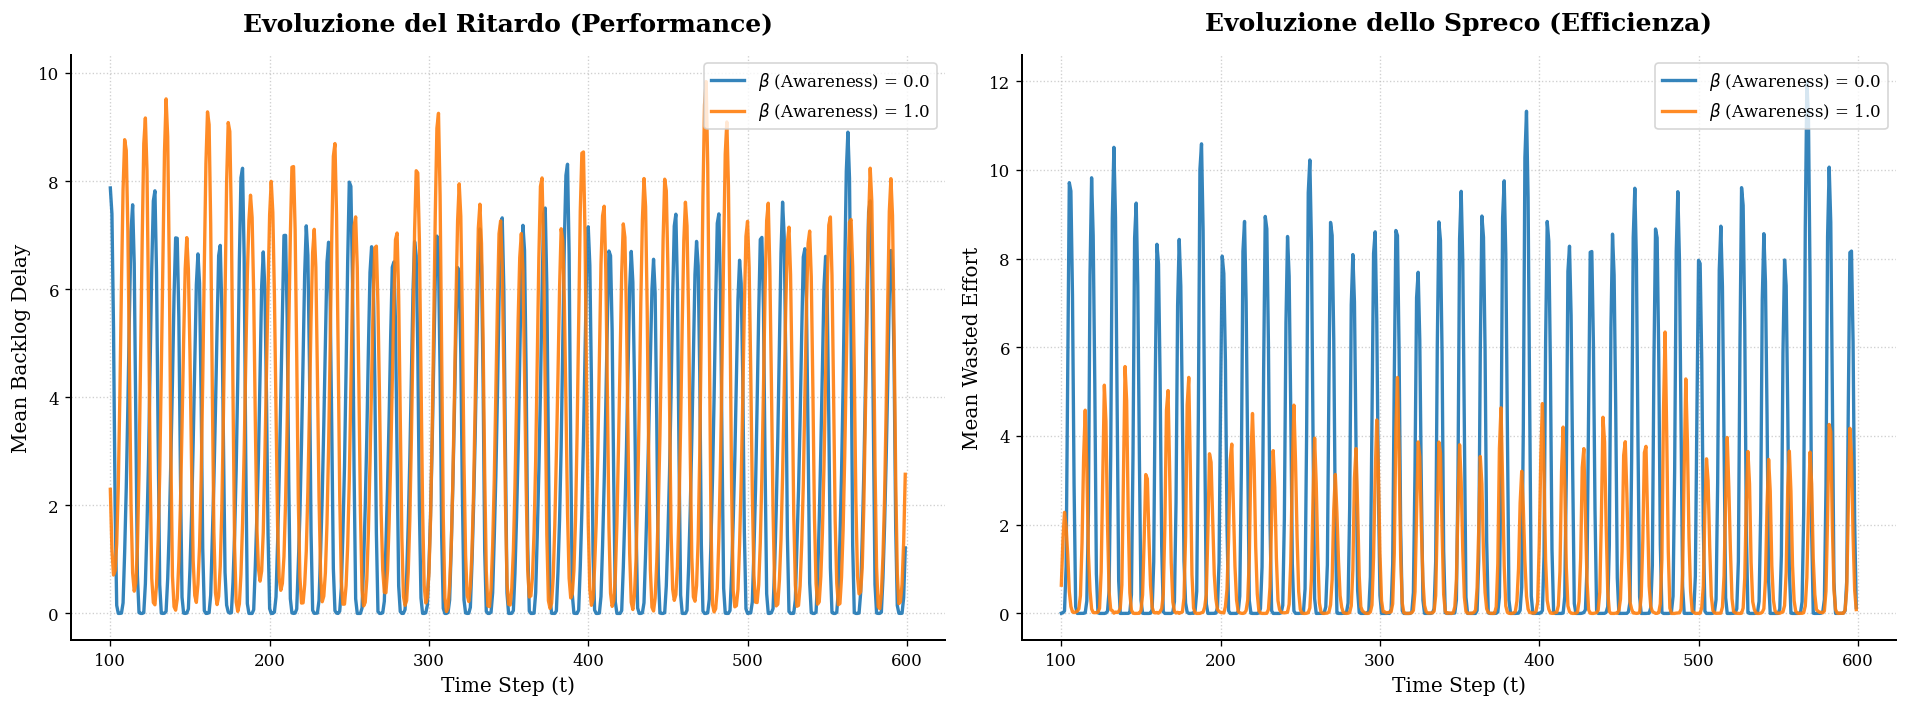

In [25]:
# Impostazioni generali per un look pulito
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2

fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=120)

# Palette di colori definita manualmente (da scuro a chiaro)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (beta, data) in enumerate(results.items()):
    color = colors[i % len(colors)]
    
    # Grafico a sinistra: Ritardo
    ax[0].plot(data['time'], data['mean_delay'], 
               label=rf'$\beta$ (Awareness) = {beta}', 
               color=color, linewidth=2, alpha=0.9)
    
    # Grafico a destra: Spreco
    ax[1].plot(data['time'], data['wasted_effort'], 
               label=rf'$\beta$ (Awareness) = {beta}', 
               color=color, linewidth=2, alpha=0.9)

# Formattazione Grafico 0
ax[0].set_title("Evoluzione del Ritardo (Performance)", fontsize=15, fontweight='bold', pad=15)
ax[0].set_xlabel("Time Step (t)", fontsize=12)
ax[0].set_ylabel("Mean Backlog Delay", fontsize=12)
ax[0].grid(True, linestyle=':', alpha=0.6)
ax[0].legend(frameon=True, fontsize=10, loc='upper right')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Formattazione Grafico 1
ax[1].set_title("Evoluzione dello Spreco (Efficienza)", fontsize=15, fontweight='bold', pad=15)
ax[1].set_xlabel("Time Step (t)", fontsize=12)
ax[1].set_ylabel("Mean Wasted Effort", fontsize=12)
ax[1].grid(True, linestyle=':', alpha=0.6)
ax[1].legend(frameon=True, fontsize=10, loc='upper right')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Simulazione Blocco B in corso...
Completato!


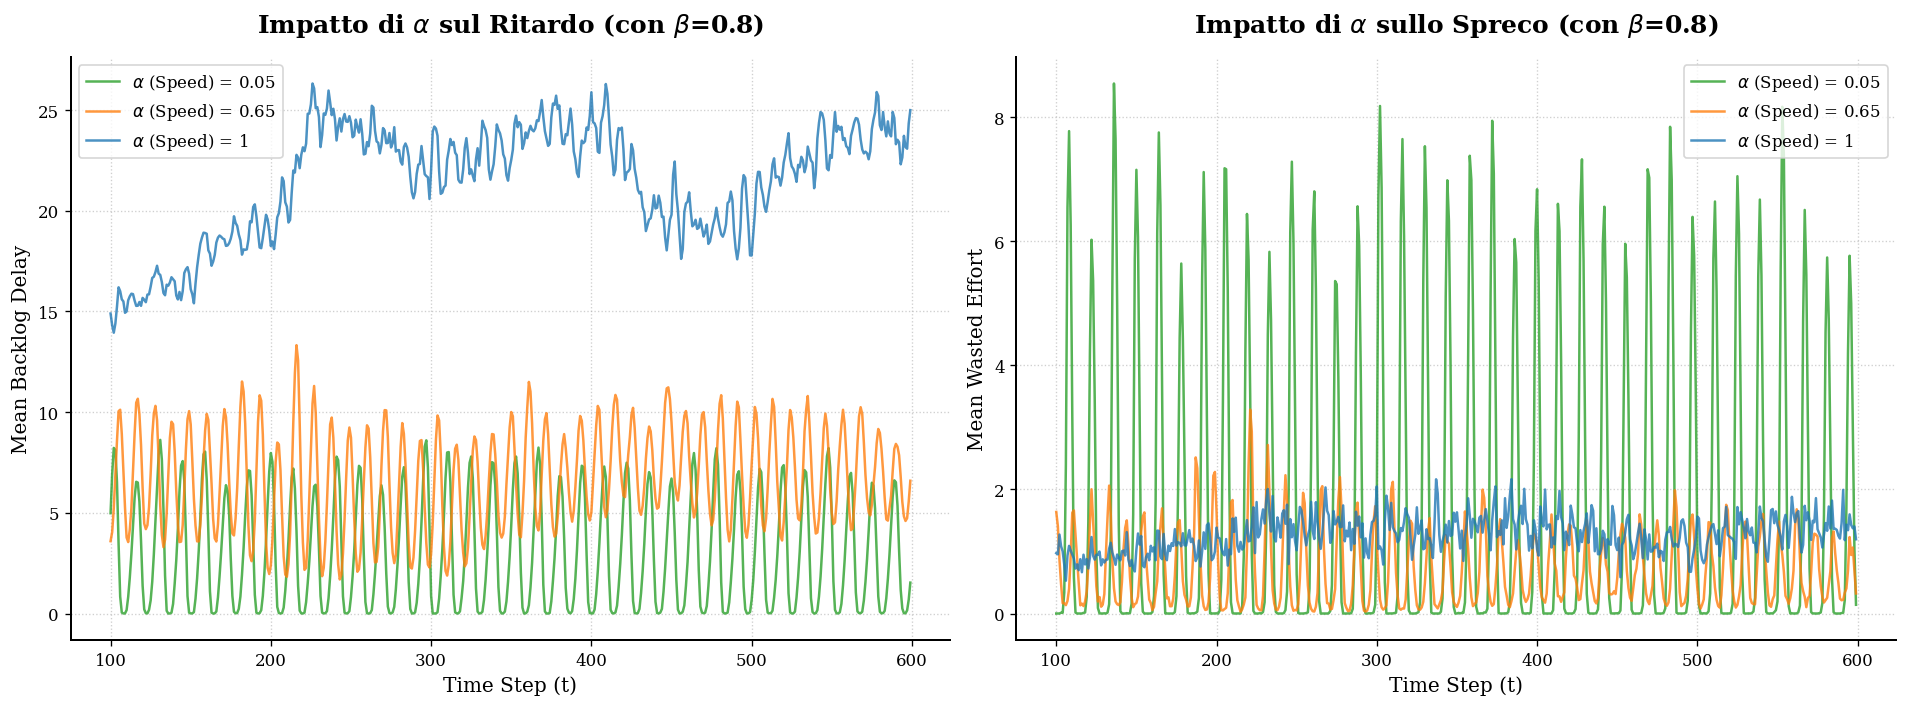

In [26]:
# --- Configurazione Blocco B ---
beta_fissato = 0.8  # Usiamo un valore intermedio di consapevolezza
alpha_values = [0.05, 0.65, 1] # Da molto lento/prudente a molto aggressivo
results_alpha = {}

print("Simulazione Blocco B in corso...")
for alpha in alpha_values:
    results_alpha[alpha] = sterman_stn_simulation(
        B=BUFFER_B, k=K_DEGREE, n=N_NODES, T=T_MAX, T_start=T_WARMUP,
        correction_speed=alpha, 
        pipeline_awareness=beta_fissato, 
        effort_lag=4 
    )
print("Completato!")

# --- Grafici Professionali (Stile Coerente) ---
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=120)

# Palette di colori per Alpha (dal blu al rosso per indicare l'aumento di aggressività)
colors_alpha = ['#2ca02c', '#ff7f0e', '#1f77b4', '#d62728']

for i, (alpha, data) in enumerate(results_alpha.items()):
    color = colors_alpha[i % len(colors_alpha)]
    
    # Grafico a sinistra: Ritardo
    ax[0].plot(data['time'], data['mean_delay'], 
               label=rf'$\alpha$ (Speed) = {alpha}', 
               color=color, linewidth=1.5, alpha=0.8)
    
    # Grafico a destra: Spreco
    ax[1].plot(data['time'], data['wasted_effort'], 
               label=rf'$\alpha$ (Speed) = {alpha}', 
               color=color, linewidth=1.5, alpha=0.8)

# Formattazione Grafico 0 (Ritardo)
ax[0].set_title(rf"Impatto di $\alpha$ sul Ritardo (con $\beta$={beta_fissato})", fontsize=15, fontweight='bold', pad=15)
ax[0].set_xlabel("Time Step (t)", fontsize=12)
ax[0].set_ylabel("Mean Backlog Delay", fontsize=12)
ax[0].grid(True, linestyle=':', alpha=0.6)
ax[0].legend(frameon=True, fontsize=10)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Formattazione Grafico 1 (Spreco)
ax[1].set_title(rf"Impatto di $\alpha$ sullo Spreco (con $\beta$={beta_fissato})", fontsize=15, fontweight='bold', pad=15)
ax[1].set_xlabel("Time Step (t)", fontsize=12)
ax[1].set_ylabel("Mean Wasted Effort", fontsize=12)
ax[1].grid(True, linestyle=':', alpha=0.6)
ax[1].legend(frameon=True, fontsize=10)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

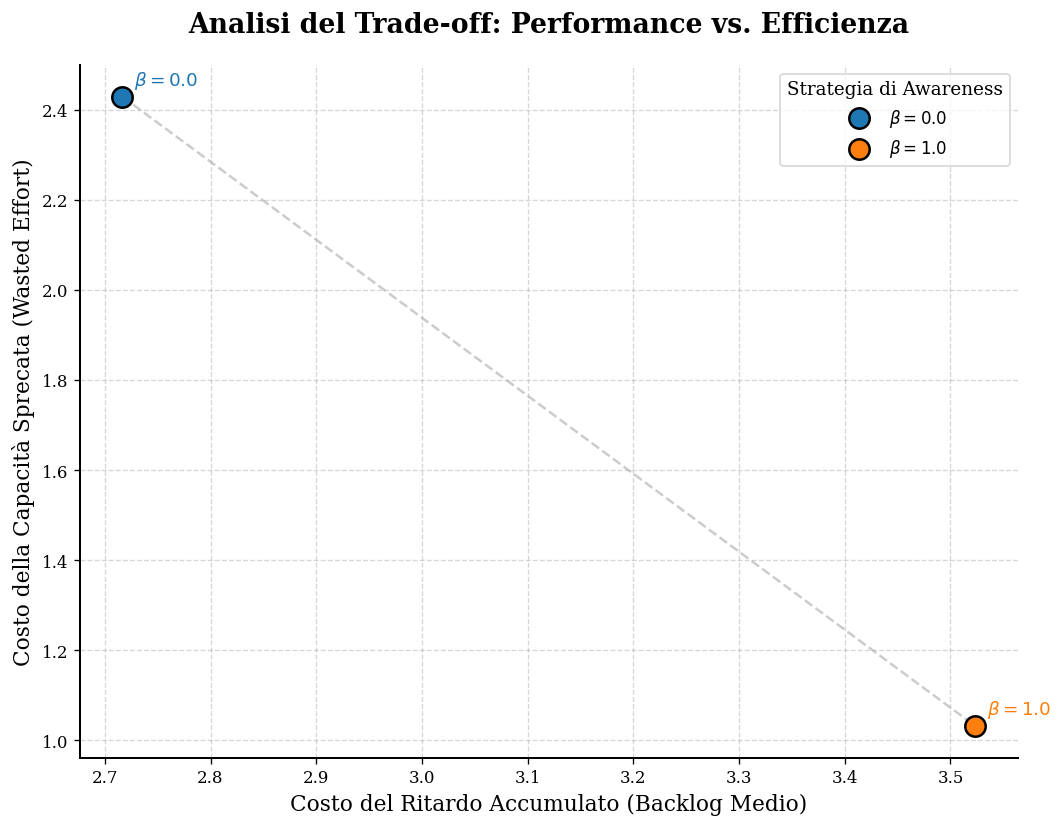

In [27]:
plt.figure(figsize=(9, 7), dpi=120)

# Calcolo medie per il trade-off
for i, (beta, data) in enumerate(results.items()):
    avg_delay = np.mean(data['mean_delay'])
    avg_waste = np.mean(data['wasted_effort'])
    color = colors[i % len(colors)]
    
    # Punto dello scatter con bordo nero per staccare dal fondo
    plt.scatter(avg_delay, avg_waste, s=150, color=color, 
                edgecolor='black', linewidth=1.5, label=rf'$\beta = {beta}$', zorder=3)
    
    # Annotazione migliorata con offset dinamico
    plt.annotate(rf'$\beta={beta}$', 
                 xy=(avg_delay, avg_waste), 
                 xytext=(7, 7), 
                 textcoords='offset points',
                 fontsize=11, fontweight='bold', color=color)

# Elementi del grafico
plt.title("Analisi del Trade-off: Performance vs. Efficienza", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Costo del Ritardo Accumulato (Backlog Medio)", fontsize=13)
plt.ylabel("Costo della Capacità Sprecata (Wasted Effort)", fontsize=13)

# Aggiunta di una linea tratteggiata che unisce i punti per mostrare la frontiera
all_delays = [np.mean(d['mean_delay']) for d in results.values()]
all_wastes = [np.mean(d['wasted_effort']) for d in results.values()]
plt.plot(all_delays, all_wastes, linestyle='--', color='gray', alpha=0.4, zorder=1)

plt.grid(True, linestyle='--', alpha=0.5, zorder=0)
plt.legend(title="Strategia di Awareness", title_fontsize='11', fontsize='10')

# Rimuovo i bordi inutili per un look moderno
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Esecuzione sweep dei parametri...


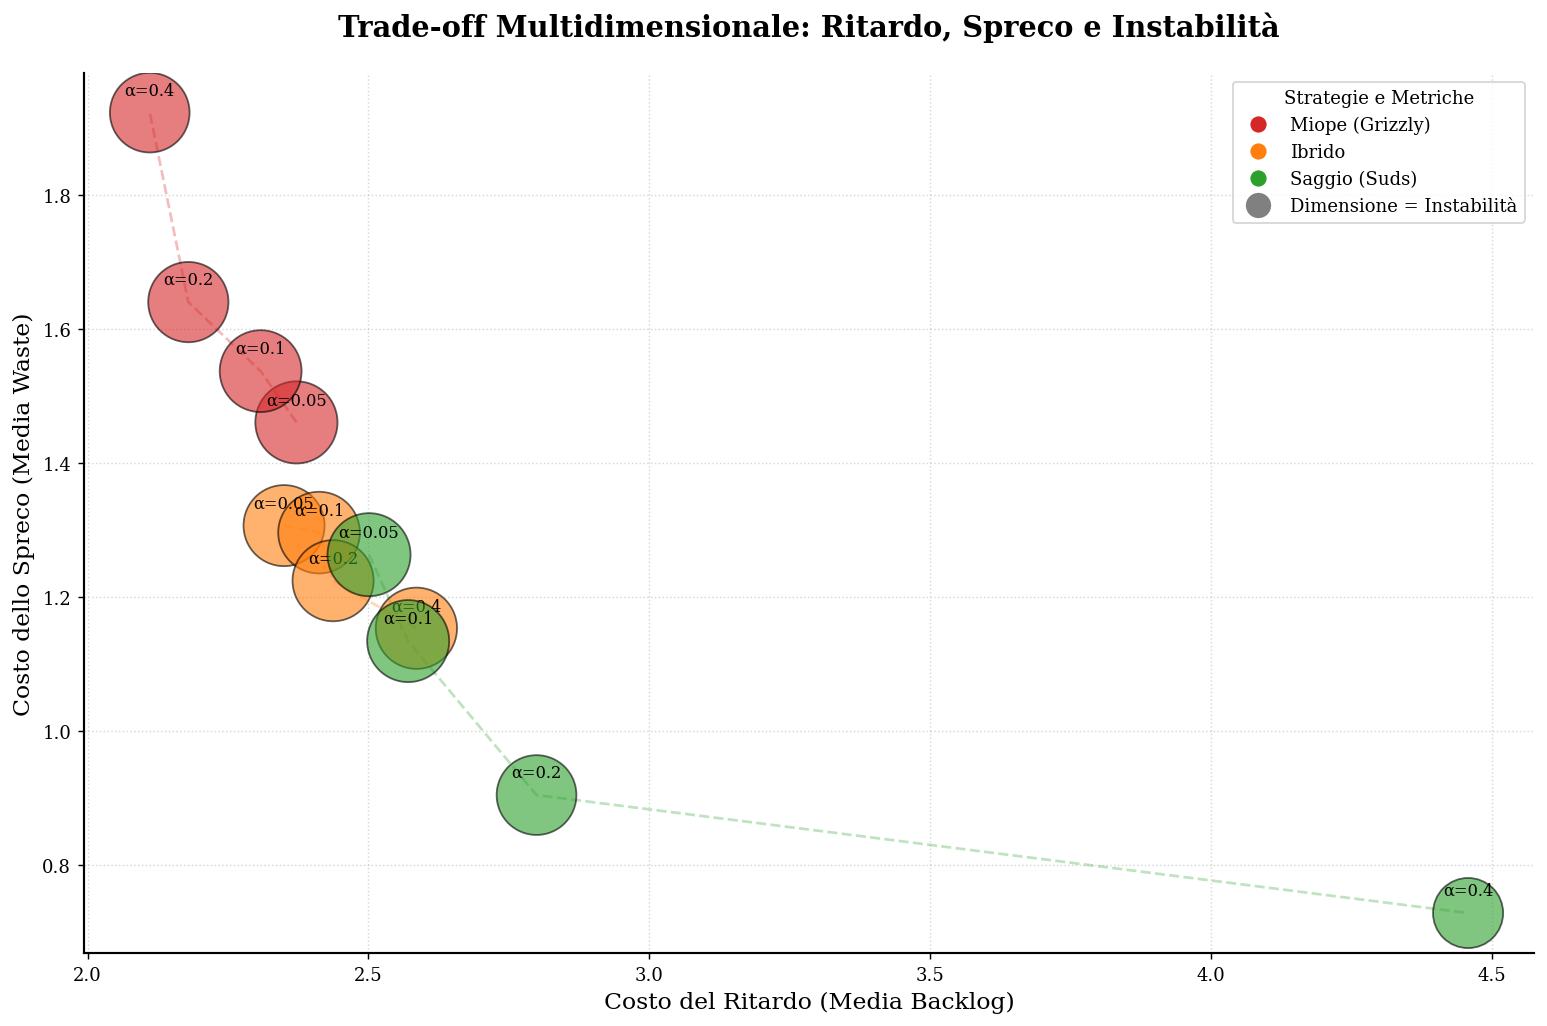

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parametri dello Sweep ---
alphas = [0.05, 0.1, 0.2, 0.4]  # Velocità di correzione
betas = [0.0, 0.5, 1.0]         # Livelli di consapevolezza
sweep_results = []

print("Esecuzione sweep dei parametri...")
for a in alphas:
    for b in betas:
        res = sterman_stn_simulation(B=1.0, k=3, n=400, T=800, T_start=200,
                                    correction_speed=a, 
                                    pipeline_awareness=b)
        sweep_results.append({
            'alpha': a,
            'beta': b,
            'mean_delay': np.mean(res['mean_delay']),
            'mean_waste': np.mean(res['wasted_effort']),
            'stability': np.std(res['mean_delay']) # Deviazione standard come misura di stabilità
        })

# --- Plotting Professionale ---
plt.figure(figsize=(12, 8), dpi=130)

# Colori per i diversi valori di Beta
colors_map = {0.0: '#d62728', 0.5: '#ff7f0e', 1.0: '#2ca02c'}
labels_map = {0.0: 'Miope (Grizzly)', 0.5: 'Ibrido', 1.0: 'Saggio (Suds)'}

for b in betas:
    subset = [r for r in sweep_results if r['beta'] == b]
    
    delays = [r['mean_delay'] for r in subset]
    wastes = [r['mean_waste'] for r in subset]
    sizes = [r['stability'] * 1000 for r in subset] # Scaliamo la dimensione per visibilità
    
    # Plot dei punti (bolle)
    plt.scatter(delays, wastes, s=sizes, color=colors_map[b], 
                alpha=0.6, edgecolors='black', label=labels_map[b], zorder=3)
    
    # Linea che connette i punti dello stesso Beta (mostra la tendenza all'aumentare di Alpha)
    plt.plot(delays, wastes, color=colors_map[b], linestyle='--', alpha=0.3, zorder=2)
    
    # Annotazioni per Alpha
    for r in subset:
        plt.annotate(f"α={r['alpha']}", (r['mean_delay'], r['mean_waste']), 
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Estetica del grafico
plt.title("Trade-off Multidimensionale: Ritardo, Spreco e Instabilità", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Costo del Ritardo (Media Backlog)", fontsize=13)
plt.ylabel("Costo dello Spreco (Media Waste)", fontsize=13)

# Legenda personalizzata per la dimensione delle bolle
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels_map[b],
                          markerfacecolor=colors_map[b], markersize=10) for b in betas]
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Dimensione = Instabilità',
                              markerfacecolor='gray', markersize=15))

plt.legend(handles=legend_elements, title="Strategie e Metriche", loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Calcolo dei costi totali per le diverse strategie...


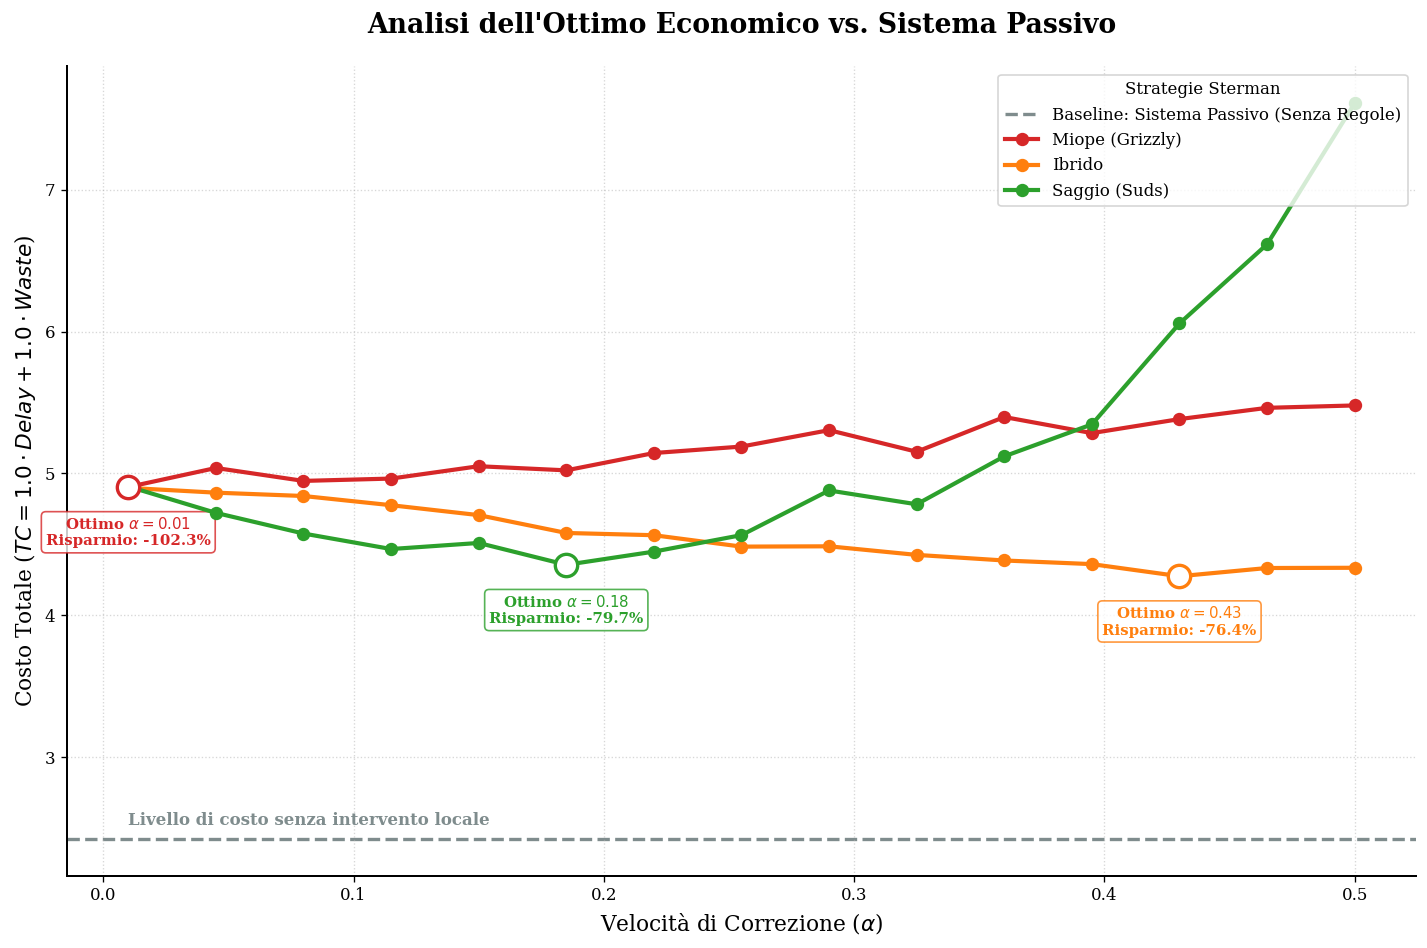

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configurazione Pesi Economici ---
w_delay = 1.0  # Peso del costo del ritardo (Backlog)
w_waste = 1.0  # Peso del costo dello sforzo sprecato (Waste)

# --- 2. Parametri del Sweep ---
alphas = np.linspace(0.01, 0.5, 15) # Range di velocità di correzione
betas = [0.0, 0.5, 1.0]
tc_results = {b: [] for b in betas}

# --- 3. Calcolo della Baseline (Sistema Passivo: alpha=0) ---
# Il sistema passivo non ha sforzo extra, quindi lo spreco è zero per definizione.
res_base = sterman_stn_simulation(B=1.0, k=3, n=500, T=1000, T_start=200,
                                 correction_speed=0, pipeline_awareness=0)
tc_baseline = (w_delay * np.mean(res_base['mean_delay'])) + (w_waste * 0)

# --- 4. Esecuzione Simulazioni per le strategie attive ---
print("Calcolo dei costi totali per le diverse strategie...")
for b in betas:
    for a in alphas:
        res = sterman_stn_simulation(B=1.0, k=3, n=500, T=1000, T_start=200,
                                    correction_speed=a, pipeline_awareness=b, effort_lag=4)
        
        avg_delay = np.mean(res['mean_delay'])
        avg_waste = np.mean(res['wasted_effort'])
        total_cost = (w_delay * avg_delay) + (w_waste * avg_waste)
        tc_results[b].append(total_cost)

# --- 5. Grafico Professionale Comparativo ---
plt.figure(figsize=(12, 8), dpi=120)
plt.rcParams['font.family'] = 'serif'

# Linea della Baseline
plt.axhline(y=tc_baseline, color='#7f8c8d', linestyle='--', linewidth=2, 
            label='Baseline: Sistema Passivo (Senza Regole)', zorder=1)

colors = {0.0: '#d62728', 0.5: '#ff7f0e', 1.0: '#2ca02c'}
labels = {0.0: 'Miope (Grizzly)', 0.5: 'Ibrido', 1.0: 'Saggio (Suds)'}

for b in betas:
    costs = tc_results[b]
    plt.plot(alphas, costs, color=colors[b], marker='o', linewidth=2.5, markersize=7, label=labels[b], zorder=3)
    
    # Identificazione dell'Ottimo Economico
    min_idx = np.argmin(costs)
    opt_alpha = alphas[min_idx]
    opt_cost = costs[min_idx]
    
    # Calcolo Risparmio rispetto alla Baseline
    savings = ((tc_baseline - opt_cost) / tc_baseline) * 100
    
    plt.scatter(opt_alpha, opt_cost, s=180, color='white', edgecolor=colors[b], linewidth=2, zorder=5)
    plt.annotate(f'Ottimo $\\alpha={opt_alpha:.2f}$\nRisparmio: {savings:.1f}%', 
                 (opt_alpha, opt_cost), xytext=(0, -35), textcoords="offset points", 
                 ha='center', fontsize=9, fontweight='bold', color=colors[b],
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec=colors[b]))

# Estetica del Grafico
plt.title("Analisi dell'Ottimo Economico vs. Sistema Passivo", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Velocità di Correzione ($\\alpha$)", fontsize=13)
plt.ylabel(f"Costo Totale ($TC = {w_delay} \cdot Delay + {w_waste} \cdot Waste$)", fontsize=13)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(title="Strategie Sterman", fontsize=10, loc='upper right')

# Riferimento testuale per la baseline
plt.text(alphas[0], tc_baseline + 0.1, 'Livello di costo senza intervento locale', 
         color='#7f8c8d', fontsize=10, fontweight='bold')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Esecuzione stress test (B=0.2, Lag=2)...


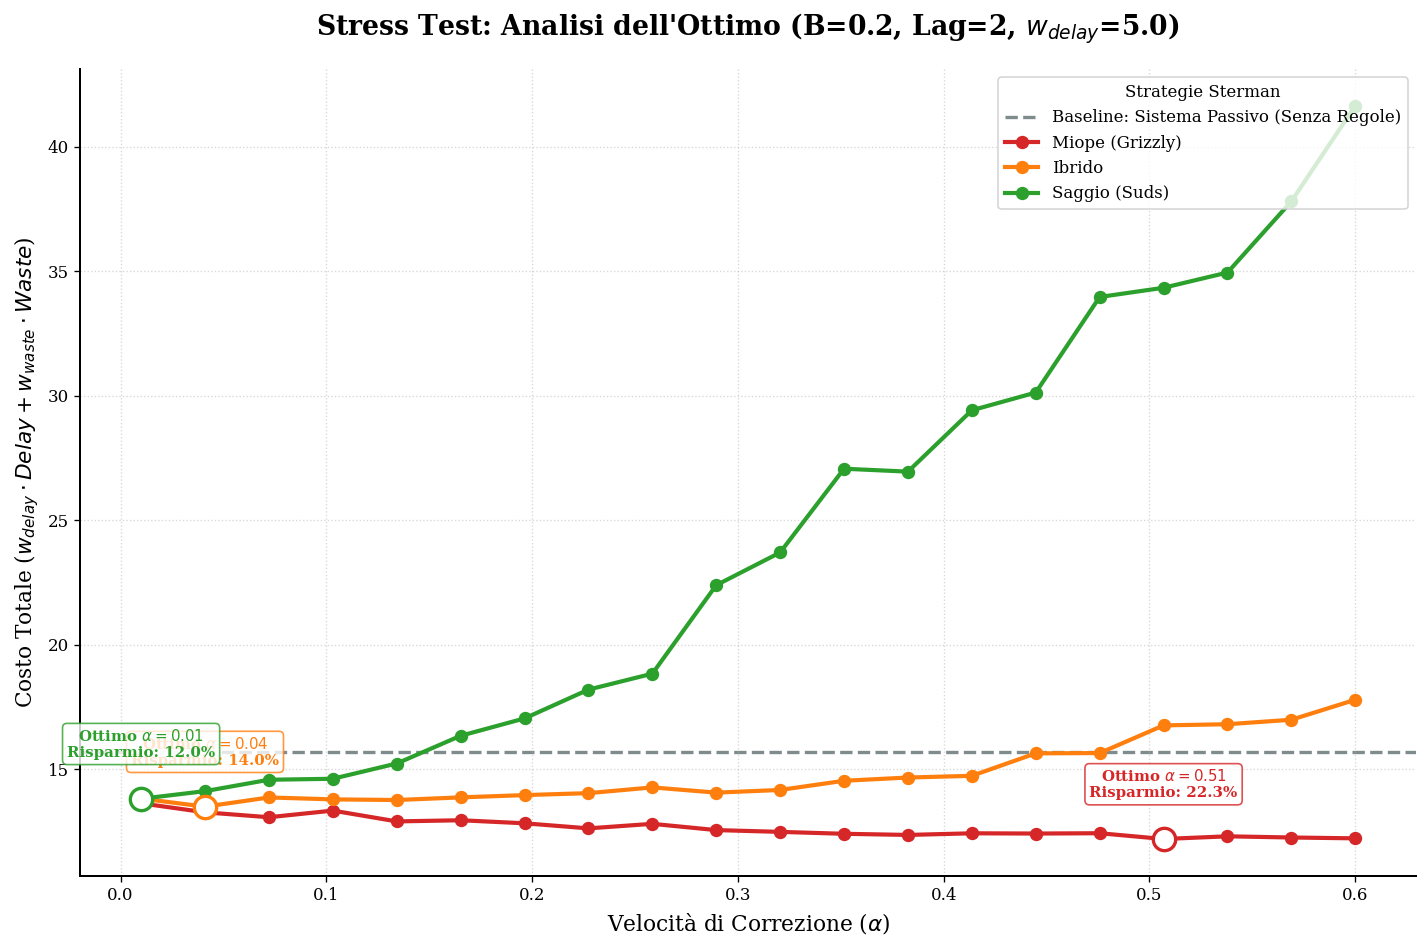

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configurazione "Stress Test" ---
w_delay = 5.0  # Incrementato: il ritardo ora è molto costoso
w_waste = 1.0  # Lo spreco ha un peso relativo minore
B_stress = 0.2 # Ridotto: meno assorbimento naturale dal buffer
L_short = 2    # Ridotto: lo sforzo è più tempestivo

# --- 2. Parametri del Sweep ---
alphas = np.linspace(0.01, 0.6, 20) 
betas = [0.0, 0.5, 1.0]
tc_results = {b: [] for b in betas}

# --- 3. Calcolo della Baseline (Sistema Passivo: alpha=0) ---
res_base = sterman_stn_simulation(B=B_stress, k=3, n=500, T=1000, T_start=200,
                                 correction_speed=0, pipeline_awareness=0)
# Il costo passivo ora sarà dominato dall'alto w_delay e dal basso buffer
tc_baseline = (w_delay * np.mean(res_base['mean_delay'])) + (w_waste * 0)

# --- 4. Esecuzione Simulazioni ---
print(f"Esecuzione stress test (B={B_stress}, Lag={L_short})...")
for b in betas:
    for a in alphas:
        res = sterman_stn_simulation(B=B_stress, k=3, n=500, T=1000, T_start=200,
                                    correction_speed=a, pipeline_awareness=b, effort_lag=L_short)
        
        avg_delay = np.mean(res['mean_delay'])
        avg_waste = np.mean(res['wasted_effort'])
        total_cost = (w_delay * avg_delay) + (w_waste * avg_waste)
        tc_results[b].append(total_cost)

# --- 5. Grafico Professionale Comparativo ---
plt.figure(figsize=(12, 8), dpi=120)
plt.rcParams['font.family'] = 'serif'

# Linea della Baseline
plt.axhline(y=tc_baseline, color='#7f8c8d', linestyle='--', linewidth=2, 
            label='Baseline: Sistema Passivo (Senza Regole)', zorder=1)

colors = {0.0: '#d62728', 0.5: '#ff7f0e', 1.0: '#2ca02c'}
labels = {0.0: 'Miope (Grizzly)', 0.5: 'Ibrido', 1.0: 'Saggio (Suds)'}

for b in betas:
    costs = tc_results[b]
    plt.plot(alphas, costs, color=colors[b], marker='o', linewidth=2.5, markersize=7, label=labels[b], zorder=3)
    
    min_idx = np.argmin(costs)
    opt_alpha = alphas[min_idx]
    opt_cost = costs[min_idx]
    
    # Calcolo Risparmio (sarà positivo se l'ottimo è sotto la baseline)
    savings = ((tc_baseline - opt_cost) / tc_baseline) * 100
    
    plt.scatter(opt_alpha, opt_cost, s=180, color='white', edgecolor=colors[b], linewidth=2, zorder=5)
    plt.annotate(f'Ottimo $\\alpha={opt_alpha:.2f}$\nRisparmio: {savings:.1f}%', 
                 (opt_alpha, opt_cost), xytext=(0, 25 if opt_cost < tc_baseline else -35), 
                 textcoords="offset points", ha='center', fontsize=9, fontweight='bold', color=colors[b],
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec=colors[b]))

plt.title(f"Stress Test: Analisi dell'Ottimo (B={B_stress}, Lag={L_short}, $w_{{delay}}$={w_delay})", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Velocità di Correzione ($\\alpha$)", fontsize=13)
plt.ylabel("Costo Totale ($w_{delay} \cdot Delay + w_{waste} \cdot Waste$)", fontsize=13)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(title="Strategie Sterman", fontsize=10, loc='upper right')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()